---
title: "Data Cleaning"
format:
    html: 
        code-fold: false
---

# Code 

Provide the source code used for this section of the project here.

If you're using a package for code organization, you can import it at this point. However, make sure that the **actual workflow steps**—including data processing, analysis, and other key tasks—are conducted and clearly demonstrated on this page. The goal is to show the technical flow of your project, highlighting how the code is executed to achieve your results.

If relevant, link to additional documentation or external references that explain any complex components. This section should give readers a clear view of how the project is implemented from a technical perspective.

Remember, this page is a technical narrative, NOT just a notebook with a collection of code cells, include in-line Prose, to describe what is going on.

## Processing Text Data
For elections from 2013-2018 and municipal election in 2021, our data is in a semicolon delimited .txt form. I create a function that can take inputs to streamline the process of reading in this data.

In [1]:
import pandas as pd
import numpy as np

# MN election results files come in a standard format. The header row for each of these files is the same.
results_header = [
    "state",
    "county_id",
    "pct_num",
    "office_id",
    "office_name",
    "muni_fips",
    "candidate_id",
    "candidate_name",
    "suffix",
    "incumbent",
    "party_id",
    "pcts_reporting",
    "tot_pcts",
    "cand_votes",
    "cand_pct",
    "pct_votes",
]


def process_txt_results(
    input_file_path, candidates_upper, candidates_lower, office_name
):
    # Read in txt file with semicolon delimiters
    raw = pd.read_csv(
        input_file_path, delimiter=";", names=results_header, encoding="utf-8"
    )

    # Filter to only include office, candidates of interest, and precincts within Hennepin County. We will filter down to Minneapolis in a later step
    processed = raw[
        (raw["office_name"] == office_name)
        & (raw["candidate_name"].isin(candidates_upper))
        & (raw["county_id"] == 27)
    ]

    # Filter columns to only include containing precinct names and each candidate's percentage of the vote in a precinct
    processed = processed.filter(
        items=["pct_num", "candidate_name", "cand_pct"], axis=1
    )

    # Pivot wider so each candidate's percentage is a column
    processed = processed.pivot(
        index="pct_num", columns="candidate_name", values="cand_pct"
    ).reset_index()

    # Rename columns for easier analysis later on
    processed.columns = ["pct_num"] + candidates_lower

    return processed

## Iterating over text data files
Now, I use my function to iterate over each of the txt files to extract one dataframe per election that I can use for further analysis

In [2]:
mayor_13 = process_txt_results(
    "../../data/raw-data/mn2013.txt",
    ["BETSY HODGES", "CAM WINTON", "DON SAMUELS", "MARK ANDREW"],
    ["hodges13", "winton13", "samuels13", "andrew13"],
    "Mayor First Choice (Minneapolis)",
)


mayor_17 = process_txt_results(
    "../../data/raw-data/mn2017.txt",
    ["Betsy Hodges", "Jacob Frey", "Nekima Levy-Pounds", "Raymond Dehn", "Tom Hoch"],
    ["hodges17", "frey17", "levy17", "dehn17", "hoch17"],
    "Mayor First Choice (Minneapolis)",
)

gov_18 = process_txt_results(
    "../../data/raw-data/mn2018.txt",
    [
        "Erin Murphy and Erin Maye-Quade",
        "Lori Swanson and Rick Nolan",
        "Tim Walz and Peggy Flanagan",
    ],
    ["murphy18", "swanson18", "walz18"],
    "Governor & Lt Governor",
)

ag_18 = process_txt_results(
    "../../data/raw-data/mn2018.txt",
    ["Debra Hilstrom", "Keith Ellison", "Matt Pelikan", "Mike Rothman", "Tom Foley"],
    ["hilstrom18", "ellison18", "pelikan18", "rothman18", "foley18"],
    "Attorney General",
)

ush_18 = process_txt_results(
    "../../data/raw-data/mn2018.txt",
    ["Ilhan Omar", "Margaret Anderson Kelliher", "Patricia Torres Ray"],
    ["omar18", "kelliher18", "ray18"],
    "U.S. Representative District 5",
)

# Processing CSV Data
Now, we use a slightly different methodology to read in results collected by our API.

In [3]:
# Adapt the default header to include the county and precinct name variables
csv_results_header = [
    "state",
    "county_id",
    "pct_num",
    "office_id",
    "office_name",
    "muni_fips",
    "candidate_id",
    "candidate_name",
    "suffix",
    "incumbent",
    "party_id",
    "pcts_reporting",
    "tot_pcts",
    "cand_votes",
    "cand_pct",
    "pct_votes",
    "county_name",
    "pct_name",
]


def process_csv_results(
    input_file_path, candidates_upper, candidates_lower, office_name
):
    # Read in txt file with semicolon delimiters
    raw = pd.read_csv(
        input_file_path,
        header=None,
        names=csv_results_header,
        skiprows=1,
        encoding="utf-8",
    )

    # Filter to only include office, candidates of interest, and precincts within Hennepin County. We will filter down to Minneapolis in a later step
    processed = raw[
        (raw["office_name"] == office_name)
        & (raw["candidate_name"].isin(candidates_upper))
        & (raw["county_id"] == 27)
    ]

    # Filter columns to only include containing precinct names and each candidate's percentage of the vote in a precinct
    processed = processed.filter(
        items=["pct_num", "candidate_name", "cand_pct"], axis=1
    )

    # Pivot wider so each candidate's percentage is a column
    processed = processed.pivot(
        index="pct_num", columns="candidate_name", values="cand_pct"
    ).reset_index()

    # Rename columns for easier analysis later on
    processed.columns = ["pct_num"] + candidates_lower

    return processed

# Iterate over CSV data
In a similar process, we now iterate over our csv data and create dataframes.

In [4]:
pres_20 = process_csv_results(
    "../../data/raw-data/mn2020pres.csv",
    ["Bernie Sanders", "Elizabeth Warren", "Joseph Biden", "Michael R. Bloomberg"],
    ["sanders20", "warren20", "biden20", "bloomberg20"],
    "U.S. Presidential Nominee",
)

ush_20 = process_csv_results(
    "../../data/raw-data/mn2020state.csv",
    ["Ilhan Omar"],
    ["omar20"],
    "U.S. Representative District 5",
)

# Processing Excel Data
The 2021 election data could not be ready by the read_csv function due to an encoding error. I suspect this is why the API pull was not working. I manually transformed the semicolon delimited .txt data by using Excel's text-to-column function. Those without a Microsoft license can follow the same methodology in Google Sheets. I then adapt the process_txt_results function to work on .xlsx files. 

In [5]:
def process_excel_results(
    input_file_path, candidates_upper, candidates_lower, office_name
):
    # Read in Excel file instead of a .txt file
    raw = pd.read_excel(input_file_path, names=results_header)

    # Filter to only include office, candidates of interest, and precincts within Hennepin County. We will filter down to Minneapolis in a later step
    processed = raw[
        (raw["office_name"] == office_name)
        & (raw["candidate_name"].isin(candidates_upper))
        & (raw["county_id"] == 27)
    ]

    # Filter columns to only include containing precinct names and each candidate's percentage of the vote in a precinct
    processed = processed.filter(
        items=["pct_num", "candidate_name", "cand_pct"], axis=1
    )

    # Pivot wider so each candidate's percentage is a column
    processed = processed.pivot(
        index="pct_num", columns="candidate_name", values="cand_pct"
    ).reset_index()

    # Rename columns for easier analysis later on
    processed.columns = ["pct_num"] + candidates_lower

    return processed

# Iterate over Excel data
In a similar process, we now iterate over each of the 2021 elections of interest and create dataframes.

In [6]:
mayor_21 = process_excel_results(
    "../../data/raw-data/mn2021.xlsx",
    ["Jacob Frey", "Kate Knuth", "Sheila Nezhad"],
    ["frey21", "knuth21", "nezhad21"],
    "Mayor First Choice (Minneapolis)",
)

structure_21 = process_excel_results(
    "../../data/raw-data/mn2021.xlsx",
    ["YES"],
    ["yes1"],
    "CITY QUESTION 1 (Minneapolis)",
)

police_21 = process_excel_results(
    "../../data/raw-data/mn2021.xlsx",
    ["YES"],
    ["yes2"],
    "CITY QUESTION 2 (Minneapolis)",
)

rent_21 = process_excel_results(
    "../../data/raw-data/mn2021.xlsx",
    ["YES"],
    ["yes3"],
    "CITY QUESTION 3 (Minneapolis)",
)

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

# Create a Combined Dataframe of Election Results
We now take each of our individual dataframes and join them based on the precinct ID column to create a single dataframe we will use in later analysis.

In [ ]:
# we start out with the list of precincts used in the 2021 elections
elections = pd.DataFrame(mayor_21["pct_num"])

# create a list of our election dataframes
elec_files = [
    mayor_21,
    structure_21,
    police_21,
    rent_21,
    ush_20,
    pres_20,
    gov_18,
    ag_18,
    ush_18,
    mayor_17,
    mayor_13,
]

# iterate over our dataframes and left join to the list of precincts.
for df in elec_files:
    elections = elections.merge(df, how="left", on="pct_num")

# save as a csv
elections.to_csv("../../data/processed-data/election_results.csv", index=False)

NameError: name 'mayor_21' is not defined

# Read in Precinct Labels
We also want to create useful labels for our precincts instead of the numeric code. The Minnesota Secretary of State provides a .txt files that matches precinct codes to precinct names. For instance, Hennepin 1415 is labeled Minneapolis Ward 2 Precinct 2, which is much easier to understand.

In [ ]:
# read in csv

pct_names_raw = pd.read_csv(
    "../../data/raw-data/pctlabels.csv",
    header=None,
    names=[
        "county_id",
        "pct_num",
        "pct_name",
        "cd",
        "ld",
        "countycomm",
        "jud",
        "soil",
        "mcd",
        "school",
    ],
    skiprows=1,
    encoding="utf-8",
    delimiter=";",
)

# filter to only Hennepin county precincts

pct_names = pct_names_raw[(pct_names_raw["county_id"] == "27")]

# Filter columns to only include containing precinct names precinct id

pct_names = pct_names.filter(items=["pct_num", "pct_name"], axis=1)

# export so the names can be appended to our data after it's been analyzed
pct_names.to_csv("../../data/processed-data/pct_names.csv", index=False)

# Read in Demographic Data
I downloaded a CSV file containing modeled demographic data on registered voters in every census block in Minnesota from the Redistricting Data Hub. These data were originally sourced from the data vendor L2 Data. There are dozens of variables, and I select only the ones of interest.

In [ ]:
# Read in demographic data csv
demo_raw = pd.read_csv("../../data/raw-data/MN_l2_comm_2020block_agg_20210902.csv")

# Select variables of interest
variable_list = [
    "geoid20",
    "total_reg",
    "age_18_19",
    "age_20_24",
    "age_25_29",
    "age_30_34",
    "age_35_44",
    "age_45_54",
    "age_55_64",
    "age_65_74",
    "age_75_84",
    "age_85over",
    "voters_gender_f",
    "eth1_hisp",
    "eth1_eur",
    "eth1_aa",
    "residence_addresses_density_avg",
    "commercialdata_dwellingtype_multi_family_dwelling",
    "commercialdata_dwellingtype_single_family_dwelling_unit",
    "commercialdata_education_bach_degree_likely",
    "commercialdata_education_less_than_hs_diploma_likely",
    "commercialdatall_home_owner_or_renter_likely_renter",
]

# filter the columns to only include variables of interest
demos = demo_raw[variable_list]
demos = demos.copy()

# create a new column for youth voters
demos["age_18_34"] = (
    demos["age_18_19"] + demos["age_20_24"] + demos["age_25_29"] + demos["age_30_34"]
)

# create a new column for older voters
demos["age_65over"] = demos["age_65_74"] + demos["age_75_84"] + demos["age_85over"]

# drop other age columns
age_cols = [
    "age_18_19",
    "age_20_24",
    "age_25_29",
    "age_30_34",
    "age_35_44",
    "age_45_54",
    "age_55_64",
    "age_65_74",
    "age_75_84",
    "age_85over",
]

demos = demos.drop(columns=age_cols, axis=1)

# create a total dwellings in block column and then drop multi family dwellings since this will be redundant in regression analysis
demos["total_dwellings"] = (
    demos["commercialdata_dwellingtype_multi_family_dwelling"]
    + demos["commercialdata_dwellingtype_single_family_dwelling_unit"]
)
demos = demos.drop(
    columns=["commercialdata_dwellingtype_multi_family_dwelling"], axis=1
)

# filter to only Hennepin County. Blocks with  geoids starting with 27053 are in Hennepin County.
demos = demos[
    (demos["geoid20"] >= 270530000000000) & (demos["geoid20"] <= 270540000000000)
]

# Aggregate Block-Level Demographics to the Precinct Level
Since our election data is available at the precinct level, we need to aggregate our block-level demographic data to precincts. Some of our data (age breaks, gender, modeled race, religion, housing type, education, and renter status) are count data and we can aggregate our data to the precinct level by simply summing the block-level counts. However, we will need to take the mean of the density column since it would not make sense to sum this rate data. Redistricting Data Hub has a census block shapefile that contains a crosswalk of census blocks to 2020 precints. We can use the dbfread package to read in the .dbf file for the shapefile and turn it into a dataframe.

In [ ]:
# load in dbfreads package
from simpledbf import Dbf5

# read in dbf file and convert to dataframe
dbf = Dbf5("../../data/raw-data/Census_Block.dbf")

crosswalk = dbf.to_dataframe()

# select only variables of interest. We will also keep census racial data since the L2 modeled racial data may not be as accurate.

crosswalk_variables = ["BLOCK", "COUNTY", "VTD", "POPULATION", "NH_WHT", "NH_DOJ_BLK"]

crosswalk = crosswalk[crosswalk_variables]
crosswalk = crosswalk.copy()

# filter to only include Hennepin County data
crosswalk = crosswalk[crosswalk["COUNTY"] == "27053"]

Now, we can join our demographic and crosswalk datasets.

In [ ]:
# First, we need to make the block column of our crosswalk dataframe numeric so the join will work properly.
# We also rename it to match the block column in demos
crosswalk["geoid20"] = pd.to_numeric(crosswalk["BLOCK"])

# We left merge to make sure that all the blocks in our demo dataset are kept. There are more blocks in the crosswalk file since it includes
# blocks with 0 population that were excluded from the original demographic dataset.
joined_demo = demos.merge(crosswalk, how="left", on="geoid20")

# Construct a new dataset with the joined data
pcts = pd.DataFrame(pd.to_numeric(joined_demo["VTD"]).unique())
pcts = pcts.sort_values([0])
pcts.columns = ["VTD"]

Now, we can begin aggregating our block-level demographic data to the precinct level

In [ ]:
# first, some of our joined count data has been read in as string data
# We create a list of the improperly formatted columns and then iterate over to set each as numeric
wrong_data_type = ["POPULATION", "NH_WHT", "NH_DOJ_BLK"]

for column in wrong_data_type:
    joined_demo[column] = pd.to_numeric(joined_demo[column])


# create list of columns that we can iterate over and sum
col_list = [
    "total_reg",
    "voters_gender_f",
    "eth1_hisp",
    "eth1_eur",
    "eth1_aa",
    "commercialdata_education_bach_degree_likely",
    "commercialdata_education_less_than_hs_diploma_likely",
    "commercialdatall_home_owner_or_renter_likely_renter",
    "age_18_34",
    "age_65over",
    "commercialdata_dwellingtype_single_family_dwelling_unit",
    "total_dwellings",
    "POPULATION",
    "NH_WHT",
    "NH_DOJ_BLK",
]

# group blocks by precinct and then sum our count data using groupby and agg
for column in col_list:
    pcts[column] = joined_demo.groupby("VTD")[column].agg("sum").reset_index(drop=True)

We must slightly modify our code for the density column as we will be averaging instead of summing.

In [ ]:
# Use the same code but use agg('mean') instead of agg('sum')
pcts["residence_addresses_density_avg"] = (
    joined_demo.groupby("VTD")["residence_addresses_density_avg"]
    .agg("mean")
    .reset_index(drop=True)
)

# Turn Count Data into Percentages
Now, we can take our dataframe with aggregated count data and make it into ratio data. We are mindful that some of our ratio will have different denominators (voters, total population, or dwellings). We iterate over each of these cases.

In [ ]:
# turn registered voter counts into ratios
voter_variables = [
    "voters_gender_f",
    "eth1_hisp",
    "eth1_eur",
    "eth1_aa",
    "commercialdata_education_bach_degree_likely",
    "commercialdata_education_less_than_hs_diploma_likely",
    "commercialdatall_home_owner_or_renter_likely_renter",
    "age_18_34",
    "age_65over",
]

for column in voter_variables:
    pcts[column] = pcts[column] / pcts["total_reg"]

# turn dwelling counts into ratios
pcts["commercialdata_dwellingtype_single_family_dwelling_unit"] = (
    pcts["commercialdata_dwellingtype_single_family_dwelling_unit"]
    / pcts["total_dwellings"]
)

# turn census counts into ratios
census_variables = ["NH_WHT", "NH_DOJ_BLK"]

for column in census_variables:
    pcts[column] = pcts[column] / pcts["POPULATION"]

# Clean up our variable names
pcts.columns = [
    "VTD",
    "total_reg",
    "female",
    "model_hispanic",
    "model_white",
    "model_black",
    "ba",
    "lesshs",
    "renter",
    "age_18_34",
    "age_65over",
    "single_family_unit",
    "total_dwellings",
    "POPULATION",
    "census_white",
    "census_black",
    "density",
]

# reset index ahead of export
pcts = pcts.reset_index(drop=True)

# export as a csv
pcts.to_csv("../../data/processed-data/pct_demos.csv", index=False)

# Merge Dataframes and Clean Up Columns
Now, we merge our dataframes based on the precinct number column. We also drop unneeded columns.

In [ ]:
# get the last 4 digits of each VTD code. These are the same as the election precinct code
nums = []
for row in pcts["VTD"]:
    nums.append(str(row)[-4:])

# create a column containing these codes
pcts["pct_num"] = pd.to_numeric(nums)

# left join with the elections dataset to keep only Minneapolis precincts
full_data = elections.merge(pcts, how="left", on="pct_num")

# we can also drop our totals columns from the demographic data since we only want to deal with rate data (except for density). the VTD column is also unnecessary
full_data = full_data.drop(labels=["total_dwellings", "POPULATION", "VTD"], axis=1)

# Missing Values
I now look at our combined dataset and decide what to do with missing values. I start by visualizing which values are missing before deciding how to proceed.

<Axes: >

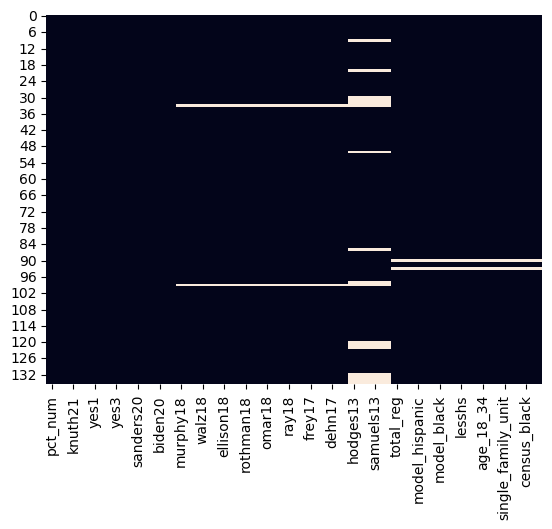

In [ ]:
# load necessary packages
import seaborn as sns
import matplotlib as plt

# Plot to show which of our values are missing
sns.heatmap(full_data.isnull(), cbar=False)

Cells with values are in black and missing values are in white. From this graph, we can see that are a few precincts that were used starting in 2020 but not before then. There are also many new precincts that were used starting in 2017 that did not exist in 2013. There are also a few precincts that were not in the dataset of demographic data. I decide that we will remove the 2013 mayoral election from our dataset because I am not confident that imputing values, either with the mean or a more advanced form of imputation, would prove accurate. I also decide to remove the precincts for which there is no demographic data or election results after 2017. 

<Axes: >

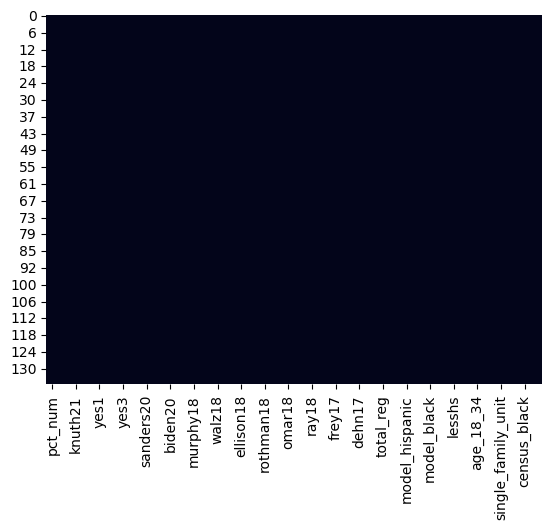

In [ ]:
# drop the 2013 elections
full_data = full_data.drop(
    labels=["hodges13", "winton13", "samuels13", "andrew13"], axis=1
)

# drop any other precincts with missing values
full_data = full_data.dropna(how="any", axis=0)

# Replot to check if any of our values are missing
sns.heatmap(full_data.isnull(), cbar=False)

# Identifying Outliers
I also want to identify outlier precincts that may have an undue influence on later analysis or seriously violate assumptions of normality. I am most focused on removing small precincts that may have skewed results simply be the fact that few voters live there and their idiosyncracies (and the variability and bias of L2's modeled demographic data) will be magnified.

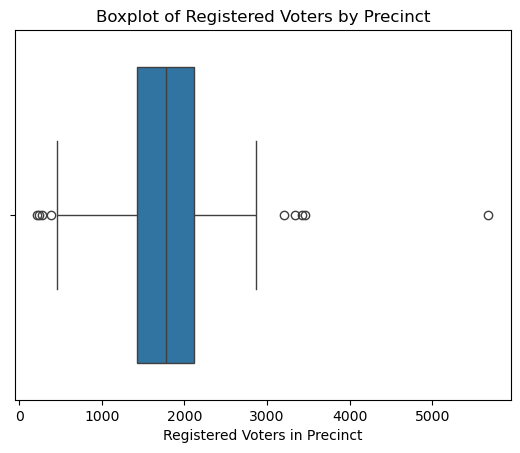

In [ ]:
box = sns.boxplot(data=full_data, x="total_reg")
box.set(
    xlabel="Registered Voters in Precinct",
    title="Boxplot of Registered Voters by Precinct",
)

From this boxplot, we can see a few precincts have a very small population of registered voters. Furthermore, given the dropoff of turnout in primary and off-year elections, the elections results in these areas will liekly be heavily skewed in one direction or another. I decide to "throw out" any precinct below the lower $1.5*IQR$ fence. I am less concerned about very large precincts, as their influence is scaled down by using ratio data as our inputs in later analysis. In fact, their large size is a boon since there is likely to be less "noise" in their election results.

In [ ]:
# filter out rows with low registered voter population

# calculate IQR
Q1 = full_data["total_reg"].quantile(0.25)
Q3 = full_data["total_reg"].quantile(0.75)
IQR = Q3 - Q1
lower_fence = Q1 - 1.5 * IQR

# keep only precincts with a registered voter population above the lower fence
full_data = full_data[full_data["total_reg"] >= lower_fence]

# Create Categorical Variables
We also want to code some categorical variables for later analysis. We are most interested in Minneapolis' 2021 elections. We create a binary variable indicating whether or not a precinct voted for Question 2, which would reorganize the Minneapolice Police Department into a Department of Public Safety. We also create multiclass variables. The first is a variable indicating which mayoral candidate won each precinct in the first round of the 2021 Mayoral election. The second is a variable indicating which Democratic Presidential canddiate won each precinct in the 2020 Democratic Presidential primary. Finally, we create a variable indicating which candidate won each precinct in the first round of the 2017 mayoral election.

In [ ]:
# create binary variable out of 2021 police referendum
# full_data['police_21']>50 creates a boolean response that is one-hot encoded by astype(int)
full_data["abolish"] = (full_data["yes2"] > 50).astype(int)

# create a categorical variable which returns the winner of each precinct in the 2021 mayoral election
full_data["mayor_winner"] = full_data[["frey21", "knuth21", "nezhad21"]].idxmax(axis=1)

# create a categorical variable which returns the winner of each precinct in the 2020 democratic presidential primary
full_data["pres_winner"] = full_data[
    ["sanders20", "warren20", "biden20", "bloomberg20"]
].idxmax(axis=1)

# create a categorical variable which returns the runner up of each precinct in the 2018 democratic attorney general primary
full_data["mayor17_winner"] = full_data[
    ["frey17", "hoch17", "dehn17", "hodges17", "levy17"]
].idxmax(axis=1)

In [ ]:
# We can now export our fully cleaned dataset for further analysis
full_data.to_csv("../../data/processed-data/full_data.csv", index=False)